<a href="https://colab.research.google.com/github/z0rdj/drena/blob/master/Pratical_Assignment_2_VGG16_Frozen_Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 2**



# **Tutorial**
Let's start by importing the torch libray.

In [ ]:
# Library imports
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.models as models

###**Initializing the network:**
*   Assign the CNN model to the GPU (if available)
*   Check the CNN architecure using torchsummary (important to check if the layers' input and output dimensions are correctly set)


In [ ]:
# Check your built CNN model
cnn_model = models.vgg16(pretrained=True)
#pretrained=True
#cnn_model = nnModel(10)
print(cnn_model.classifier[6].out_features) # 1000 
print("CNN Architecture: "+ str(cnn_model))



# Freeze training for all layers
#for param in cnn_model.features.parameters():
#   param.require_grad = True
lt=2
child_counter=0

child_counter = 0
for child in cnn_model.children():
     #print(" child", child_counter, "is:")
     #print(child)
     if child_counter < lt:
          print(" child", child_counter, "is frozen")
          print(child)
          for param in child.parameters():
               param.requires_grad = False
     child_counter += 1
# Newly created modules have require_grad=True by default
num_features = cnn_model.classifier[6].in_features
features = list(cnn_model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 10)]) # Add our layer with 10 outputs
cnn_model.classifier = nn.Sequential(*features) # Replace the model classifier
print(cnn_model)





device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('\nThe model will run on', device)
cnn_model = cnn_model.to(device)

# Using the torchsummary, you can check your network in more detail
import torchsummary
print("\n\n")
torchsummary.summary(cnn_model, input_size = (3, 64, 64), batch_size = 5) 



1000
CNN Architecture: VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2

## **Dataset**

####**Dataset**
MNIST database - a set ot 70,000 28×28 pixel grayscale images of handwritten digits (a training set with 60,000 examples, and a test set with 10,000 examples)

**Goal:** Classify images of handwritten digits into one of 10 classes representing the values from 0 to 9.



In [ ]:
# Library imports
from torchvision . datasets import CIFAR10
import torchvision . transforms as tt
import numpy as np

transform = tt.Compose([
                        tt.Resize(64),
                        #tt.CenterCrop(58),
                        tt.RandomHorizontalFlip(p=0.3),
                        tt.ToTensor(),
                        tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                                    ])
training_data = CIFAR10 ( download = True , root ="./ data ", transform = transform )
testing_data = CIFAR10 ( root ="./ data ", train = False , transform = transform )
from torch.utils.data.sampler import SubsetRandomSampler # Sampler 

Files already downloaded and verified


In [ ]:
# Download the dataset online available on PyTorch 
# Transform

# [
#   transforms.RandomResizedCrop(32)
#   transforms.Rando
# ]

# transform = transforms.ToTensor()

# training_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
# testing_data  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Dataset is already divided in training and testing. 
# However, to analize the model over the training step, and also perform cross-validation, the training set must be divided in two parts:
#   Training Set (80%)
#   Validation Set (20%)

# Lets start to obtain training indices
num_train = len(training_data)
print("Number of images in original training set: " + str(num_train)) # 60 000
indices = list(range(num_train))

# Randomly Shuffle
np.random.shuffle(indices)

# Split 80%/20%
split = int(np.floor(num_train * 0.2)) # 12 000
print("Split Number: " + str(split))
training_idx, valid_idx = indices[split:], indices[:split] # 48 000 / 12 000
print("Number of training images: " + str(len(training_idx)))
print("Number of validation images: " + str(len(valid_idx)))

# Lets also see how many images are on testing set
print("Number of images in the testing set: " + str(len(testing_data))) # 10 000

Number of images in original training set: 50000
Split Number: 10000
Number of training images: 40000
Number of validation images: 10000
Number of images in the testing set: 10000


In [ ]:
# To train the network, you must "encode" the data into a PyTorch dataloader
# Since you divided the original training set in 2, now you need to assign the indices to the samples
training_sampler = SubsetRandomSampler(training_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

batch_size = 64 # 16 images per batch

# Training Set
training_loader = torch.utils.data.DataLoader(dataset = training_data, \
                                              batch_size = batch_size, \
                                              sampler = training_sampler)

# Validation Set
valid_loader = torch.utils.data.DataLoader(dataset = training_data, \
                                           batch_size = batch_size, \
                                           sampler = valid_sampler)

# Testing Set
# Here, you do not need the "sampler" input, since you did not change the original testing set
testing_loader = torch.utils.data.DataLoader(dataset = testing_data, \
                                           batch_size = batch_size, \
                                           shuffle = True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

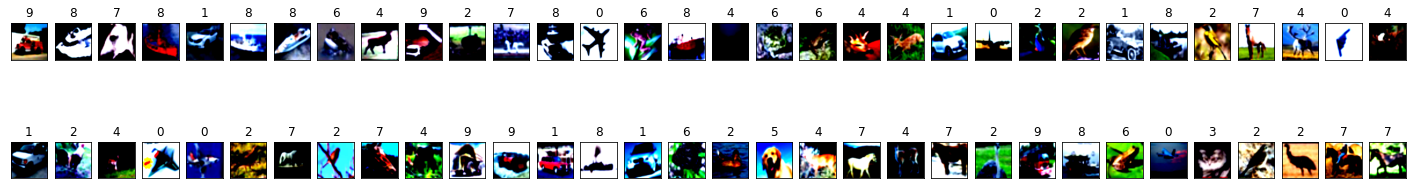

In [ ]:
# Visualization of a whole batch
import matplotlib.pyplot as plt

# Get images
dataiter = iter(training_loader)
images, labels = dataiter.next() # Get the images and their labels

# Plot the whole batch 
fig = plt.figure(figsize=(25, 4))
# Loop over all the images in the batch(16)
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    # Subplot with the image 
    plt.imshow(np.transpose(images[idx],(1,2,0)))
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

## **Training**

In [ ]:
# Library imports
import torch.optim as optim

In [ ]:
# To train a CNN, you must choose (or develop) a loss function, an optimizer algorithm, and a set of hyper-parameters (learning rate, number of epochs, etc)
# Hyper-parameters
lr = 0.0001
num_epochs = 10
#
xloss=[]
yloss=[]
yloss_val=[]
acc=[]
for i in range(num_epochs):
  xloss=np.append(xloss,i+1)
# Loss Function
criterion = nn.CrossEntropyLoss() # Cross entropy loss function is widely used in classification problems
# Optimizer Algorithm
optimizer = optim.Adam(cnn_model.parameters(), lr = lr, weight_decay=0.001)
#optimizer = torch.optim.SGD(cnn_model.parameters(), lr)
# LR scheduler 
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4], gamma=0.1)

# Training
running_loss = 0.0

for epoch in range(num_epochs):
  for batch_id, data in enumerate(training_loader, 0):
    # Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Pass images through the CNN
    outputs = cnn_model(images)

    # Create a loss value
    loss = criterion(outputs, labels)

    # Backpropagation
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward()
    optimizer.step()

    # Check some statistics
    running_loss += loss.item()
    if batch_id % 625 == 624: # prints every 1000 batchs
      print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_id + 1, running_loss / 625))
      yloss=np.append(yloss,(running_loss/(625*batch_size)))
      running_loss = 0.0
    
  # For each epoch, analize the model performance
  valid_correct = 0
  valid_total = 0
  valid_total_loss = 0
  with torch.no_grad(): # In this part, you will not train, so you don't need to calculate gradients
    for valid_batch_id, valid_data in enumerate(valid_loader, 0):
      valid_images, valid_labels = valid_data
      valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)
      valid_outputs = cnn_model(valid_images)
      valid_loss = criterion(valid_outputs, valid_labels)
      valid_total_loss += valid_loss.item()
      _, valid_predicted = torch.max(valid_outputs.data, 1)
      valid_total += valid_labels.size(0)
      valid_correct += (valid_predicted == valid_labels).sum().item()
  print("(Validation Set) Epoch: " + str(epoch + 1) + " Loss: " + str(valid_total_loss/ len(valid_idx)) + " Acc: " + str(100*valid_correct/valid_total))
  yloss_val=np.append(yloss_val,valid_total_loss/ len(valid_idx))
  acc=np.append(acc,100*valid_correct/valid_total)
  scheduler.step()
print("Training is completed!")
plt.plot(xloss,yloss_val)
plt.plot(xloss,yloss)
plt.title("Loss per Epoch plot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Loss validation","Loss training"])
plt.show()


plt.plot(xloss,acc)
plt.title("Validation Set Acc per Epoch plot")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(["Acc"])
plt.show()


[1,   625] loss: 0.784
(Validation Set) Epoch: 1 Loss: 0.010843181467056274 Acc: 76.05
[2,   625] loss: 0.605
(Validation Set) Epoch: 2 Loss: 0.010069518473744392 Acc: 77.85
[3,   625] loss: 0.470
(Validation Set) Epoch: 3 Loss: 0.009017709121108055 Acc: 80.49
[4,   625] loss: 0.423
(Validation Set) Epoch: 4 Loss: 0.008951258991658688 Acc: 80.55
[5,   625] loss: 0.390
(Validation Set) Epoch: 5 Loss: 0.008607725949585438 Acc: 81.58
[6,   625] loss: 0.388
(Validation Set) Epoch: 6 Loss: 0.008791392463445664 Acc: 81.07


## **Testing**

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Evaluate a CNN is similar to the training process without the backpropagation.
# To evaluate a CNN, we need to follow the evaluation metrics
labelsv=[]
labelsp=[]
num_classes = 10
correct = 0
total = 0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
conf_matrix =[[0 for x in range(num_classes)] for y in range(num_classes)]

cnn_model.eval()

with torch.no_grad(): # You are not training, so you don't need to calculate gradients
  for batch_id, data in enumerate(testing_loader, 0):
    # Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Calculate the CNN's predictions by running images through the network
    outputs = cnn_model(images)

    # The class with the highest
    _, predicted = torch.max(outputs.data, 1)

    # Get model's performance
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    c = (predicted == labels).squeeze()

    for i in range(len(images)):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1
    
    conf_matrix+=confusion_matrix(predicted.cpu(), labels.cpu(),labels=[x for x in range( num_classes )])
    labelsv=np.append(labelsv,labels.cpu())
    labelsp=np.append(labelsp,predicted.cpu())
# Show model's performance
print('Accuracy using {} test images: {} %\n'.format(total,100 * correct / total))
# Performance per Class
for i in range(num_classes):
  if class_total[i] == 0:
    print('Accuracy of %2s : %2d %% in %d Images' % (i, 0, 0))
  else:
    print('Accuracy of %2s : %2d %% in %d Images' % (i, 100 * class_correct[i] / class_total[i], class_total[i]))
print(f1_score(labelsv, labelsp, average=None))
# Confusion Matrix
print('\nConfusion Matrix')
print(conf_matrix)
print(classification_report(labelsv, labelsp, labels=[1, 2, 3, 4, 5 ,6 ,7 ,8 ,9]))
 
